# Advanced Analyses & Reporting
Deep-dive analyses including copy number variation inference, trajectory analysis, integration with TCGA/METABRIC, and publication-ready figure generation.

In [1]:
# IMPORTS & PATHS
from __future__ import annotations
from pathlib import Path
import warnings, os, tempfile
warnings.filterwarnings('ignore')
os.environ.setdefault('NUMBA_CACHE_DIR',
    str(Path(tempfile.gettempdir()) / 'numba_cache'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import scanpy as sc
import squidpy as sq

rcParams['font.family'] = 'DejaVu Sans'
sc.settings.verbosity  = 3

cwd = Path.cwd().resolve()
if (cwd / 'README.md').exists() and (cwd / 'data').exists():
    project_root = cwd
elif (cwd.parent / 'README.md').exists():
    project_root = cwd.parent
else:
    raise RuntimeError(f'Cannot locate project root from cwd={cwd}.')

processed_dir  = project_root / 'data' / 'processed'
fig_adv_dir    = project_root / 'figures' / 'advanced'
fig_report_dir = project_root / 'figures' / 'report'

for d in [fig_adv_dir, fig_report_dir]:
    d.mkdir(parents=True, exist_ok=True)

sc.settings.figdir = str(fig_adv_dir)
print(f"Scanpy  : {sc.__version__}")
print(f"Squidpy : {sq.__version__}") 

Scanpy  : 1.12
Squidpy : 1.8.1


In [2]:
# LOAD ADATA
adata = sc.read_h5ad(processed_dir / 'adata_cellcomm.h5ad')

print(adata)
print(f"\nSpots      : {adata.n_obs:,}")
print(f"Genes      : {adata.n_vars:,}")
print(f"Cell types : {adata.obs['cell_type'].nunique()}")

# Check all score columns are present
score_cols = [c for c in adata.obs.columns if c.startswith('score_')]
lr_cols    = [c for c in adata.obs.columns if c.startswith('lr_')]
print(f"Signature scores : {len(score_cols)}")
print(f"LR scores        : {len(lr_cols)}")

AnnData object with n_obs × n_vars = 4869 × 21349
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'leiden_0.3', 'leiden_0.5', 'leiden_0.6', 'leiden_1.0', 'leiden', 'cell_type', 'score_Tumor_Epithelial', 'score_Luminal_A', 'score_HER2_Enriched', 'score_Basal_Like', 'score_Proliferating', 'score_CAFs', 'score_Myofibroblasts', 'score_Endothelial', 'score_Adipocytes', 'score_T_Cells', 'score_CD8_T_Cells', 'score_CD4_T_Cells', 'score_Tregs', 'score_B_Cells', 'score_Plasma_Cells', 'score_Macrophages_M1', 'score_Macrophages_M2', 'score_NK_Cells', 'score_Mast_Cells', 'score_Dendritic_Cells', 'score_TLS_signature', 'score_Hypoxia', 'score_EMT', 'score_Exhausted_T', 'lr_PD-

In [3]:
# PAM50 SUBTYPE SCORING
# Score each spot for the 5 PAM50 molecular subtypes
# This confirms the molecular subtype spatially

pam50_sigs = {
    'PAM50_LuminalA'  : ['ESR1','PGR','FOXA1','GATA3',
                         'BCL2','MYB','NAT1','MAPT'],
    'PAM50_LuminalB'  : ['ESR1','MKI67','CCNB1','TOP2A',
                         'ERBB2','GRB7'],
    'PAM50_HER2enr'   : ['ERBB2','GRB7','PGAP3','STARD3',
                         'MIEN1','ORMDL3'],
    'PAM50_BasalLike' : ['KRT5','KRT14','KRT17','TP63',
                         'EGFR','CDH3','LAMC2'],
    'PAM50_Normal'    : ['ADIPOQ','FABP4','PLIN1',
                         'CEBPA','LPL'],
}

print("PAM50 Subtype Scoring:")
for name, genes in pam50_sigs.items():
    found = [g for g in genes if g in adata.var_names]
    if len(found) >= 2:
        sc.tl.score_genes(
            adata,
            gene_list=found,
            score_name=name,
            use_raw=True,
            random_state=42
        )
        print(f"  {name:<22} ({len(found)}/{len(genes)} genes)")
    else:
        print(f"  {name:<22} skipped ({len(found)} genes)")

# Assign dominant subtype per spot
pam50_cols = [c for c in pam50_sigs.keys()
              if c in adata.obs.columns]
adata.obs['PAM50_subtype'] = \
    adata.obs[pam50_cols].idxmax(axis=1)\
         .str.replace('PAM50_','')

print(f"\nPAM50 subtype distribution:")
print(adata.obs['PAM50_subtype'].value_counts())

PAM50 Subtype Scoring:
computing score 'PAM50_LuminalA'
    finished: added
    'PAM50_LuminalA', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)
  PAM50_LuminalA         (8/8 genes)
computing score 'PAM50_LuminalB'
    finished: added
    'PAM50_LuminalB', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
  PAM50_LuminalB         (6/6 genes)
computing score 'PAM50_HER2enr'
    finished: added
    'PAM50_HER2enr', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
  PAM50_HER2enr          (6/6 genes)
computing score 'PAM50_BasalLike'
    finished: added
    'PAM50_BasalLike', score of gene set (adata.obs).
    349 total control genes are used. (0:00:00)
  PAM50_BasalLike        (7/7 genes)
computing score 'PAM50_Normal'
    finished: added
    'PAM50_Normal', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
  PAM50_Normal           (5/5 genes)

PAM50 subtype distributio

Saved figures/advanced/01_PAM50_scores.png
Saved figures/advanced/02_PAM50_dominant.png


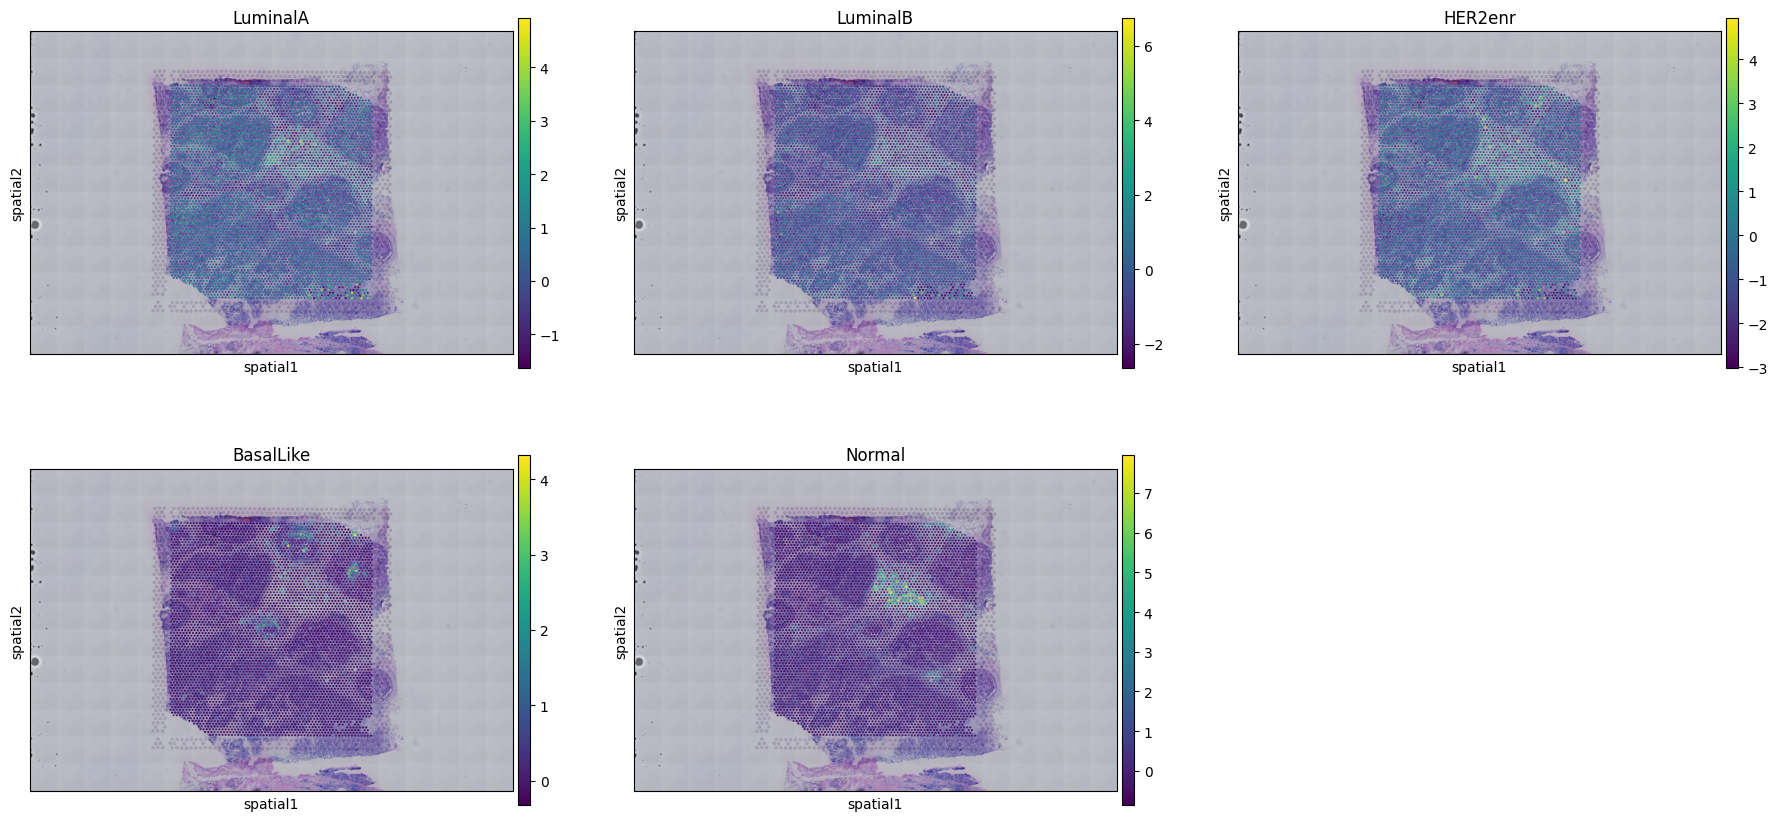

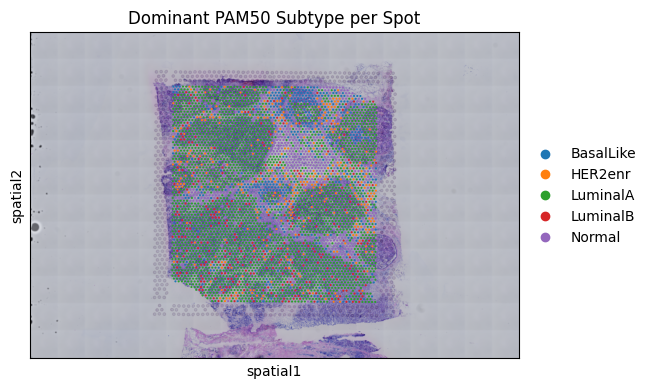

In [5]:
# PAM50 SPATIAL MAP
prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_adv_dir)

# Individual subtype scores
sq.pl.spatial_scatter(
    adata,
    color=pam50_cols,
    ncols=3,
    use_raw=False,
    title=[c.replace('PAM50_','') for c in pam50_cols],
    save='_01_PAM50_scores.png'
)

# Dominant subtype per spot
sq.pl.spatial_scatter(
    adata,
    color='PAM50_subtype',
    title='Dominant PAM50 Subtype per Spot',
    save='_02_PAM50_dominant.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/advanced/01_PAM50_scores.png")
print("Saved figures/advanced/02_PAM50_dominant.png")  

In [6]:
# PROGENY PATHWAY ACTIVITY 
# PROGENy scores 14 cancer-relevant pathways
# using a footprint approach on downstream target genes

progeny_sigs = {
    'PROG_EGFR'    : ['DUSP4','DUSP6','EGR1','EREG',
                      'HBEGF','MYC','SPRY2'],
    'PROG_Hypoxia' : ['ALDOA','CA9','BNIP3','HIF1A',
                      'LDHA','SLC2A1','VEGFA','PGK1'],
    'PROG_PI3K'    : ['AKT1','FOXO1','GSK3B','PTEN',
                      'RPS6KB1','TSC2'],
    'PROG_p53'     : ['BAX','BBC3','CDKN1A','MDM2',
                      'PUMA','TIGAR','TP53'],
    'PROG_WNT'     : ['AXIN2','CCND1','MYC','TCF7',
                      'LEF1','CTNNB1'],
    'PROG_TNFa'    : ['CCL2','CXCL1','CXCL10','IL6',
                      'IL8','NFKB1','PTGS2'],
    'PROG_MAPK'    : ['DUSP4','DUSP6','EGR1','FOS',
                      'JUN','SPRY2'],
    'PROG_JAK_STAT': ['IRF1','IRF9','MX1','OAS1',
                      'SOCS1','STAT1','STAT3'],
    'PROG_TGFb'    : ['COL1A1','COL3A1','FN1','MMP2',
                      'SERPINE1','TGFB1','THBS1'],
    'PROG_Trail'   : ['BIRC3','CASP3','CASP8','FAS',
                      'TNFRSF10A','TNFRSF10B'],
}

print("PROGENy Pathway Scoring:")
for name, genes in progeny_sigs.items():
    found = [g for g in genes if g in adata.var_names]
    if len(found) >= 2:
        sc.tl.score_genes(
            adata,
            gene_list=found,
            score_name=name,
            use_raw=True,
            random_state=42
        )
        print(f"   {name:<18} ({len(found)}/{len(genes)} genes)")
    else:
        print(f"    {name:<18} skipped")

prog_cols = [c for c in progeny_sigs.keys()
             if c in adata.obs.columns]
print(f"\n {len(prog_cols)} PROGENy pathways scored") 

PROGENy Pathway Scoring:
computing score 'PROG_EGFR'
    finished: added
    'PROG_EGFR', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)
   PROG_EGFR          (7/7 genes)
computing score 'PROG_Hypoxia'
    finished: added
    'PROG_Hypoxia', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)
   PROG_Hypoxia       (8/8 genes)
computing score 'PROG_PI3K'
    finished: added
    'PROG_PI3K', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
   PROG_PI3K          (6/6 genes)
computing score 'PROG_p53'
    finished: added
    'PROG_p53', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
   PROG_p53           (6/7 genes)
computing score 'PROG_WNT'
    finished: added
    'PROG_WNT', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)
   PROG_WNT           (6/6 genes)
computing score 'PROG_TNFa'
    finished: added
    'PROG_TNFa', score of gene set 

Saved figures/advanced/03_progeny_spatial.png


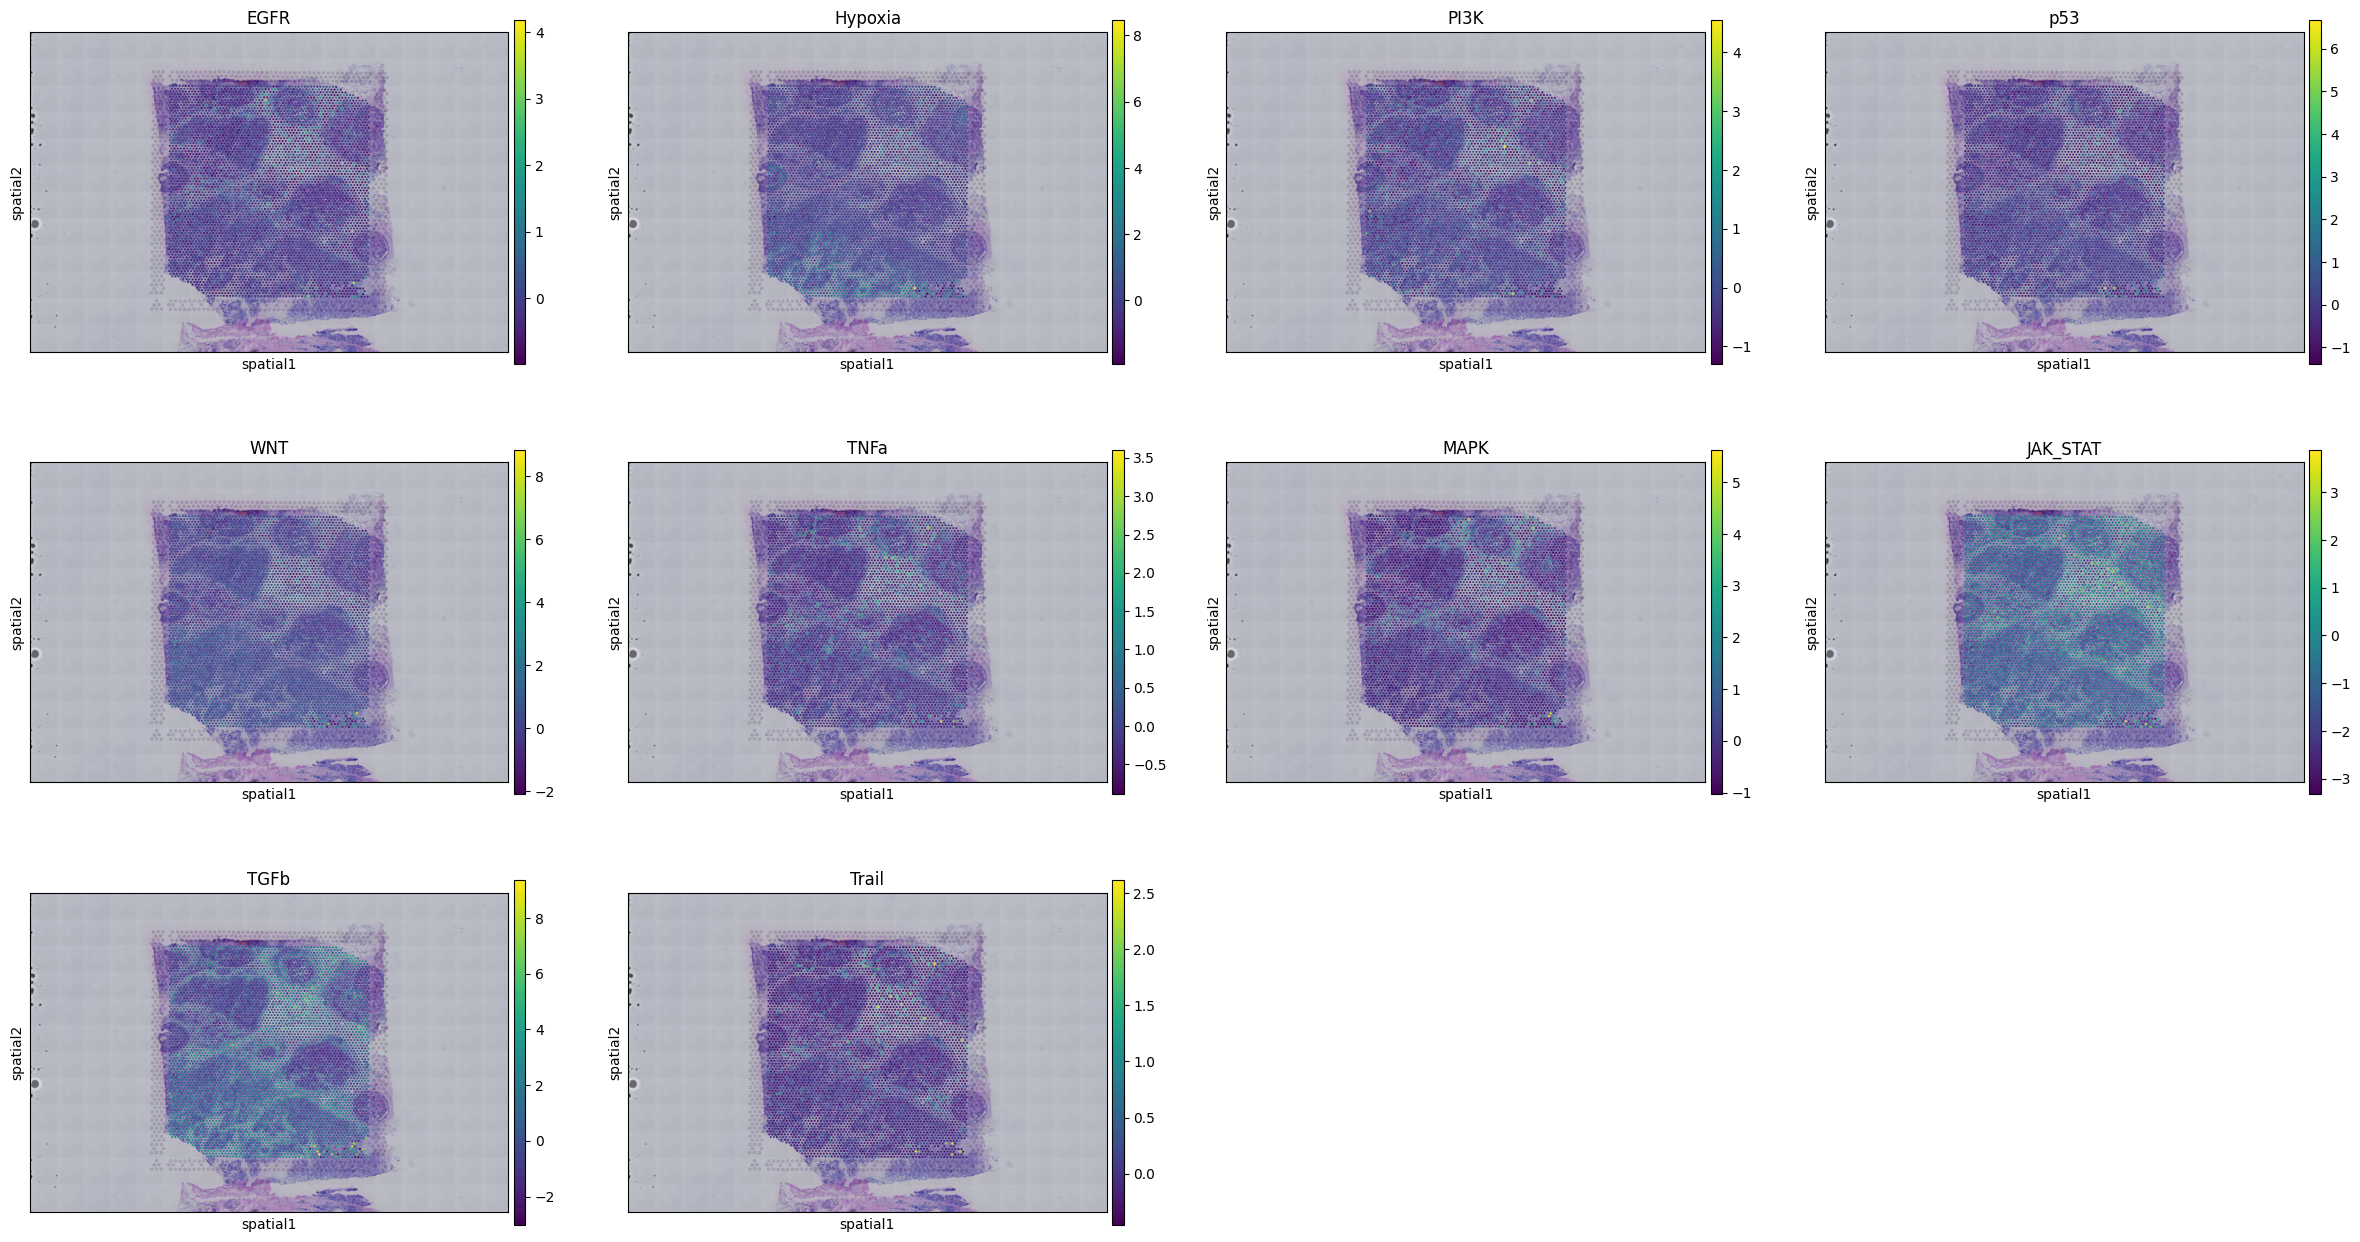

In [7]:
# PROGENY SPATIAL MAPS
prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_adv_dir)

sq.pl.spatial_scatter(
    adata,
    color=prog_cols,
    ncols=4,
    use_raw=False,
    title=[c.replace('PROG_','') for c in prog_cols],
    save='_03_progeny_spatial.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/advanced/03_progeny_spatial.png") 

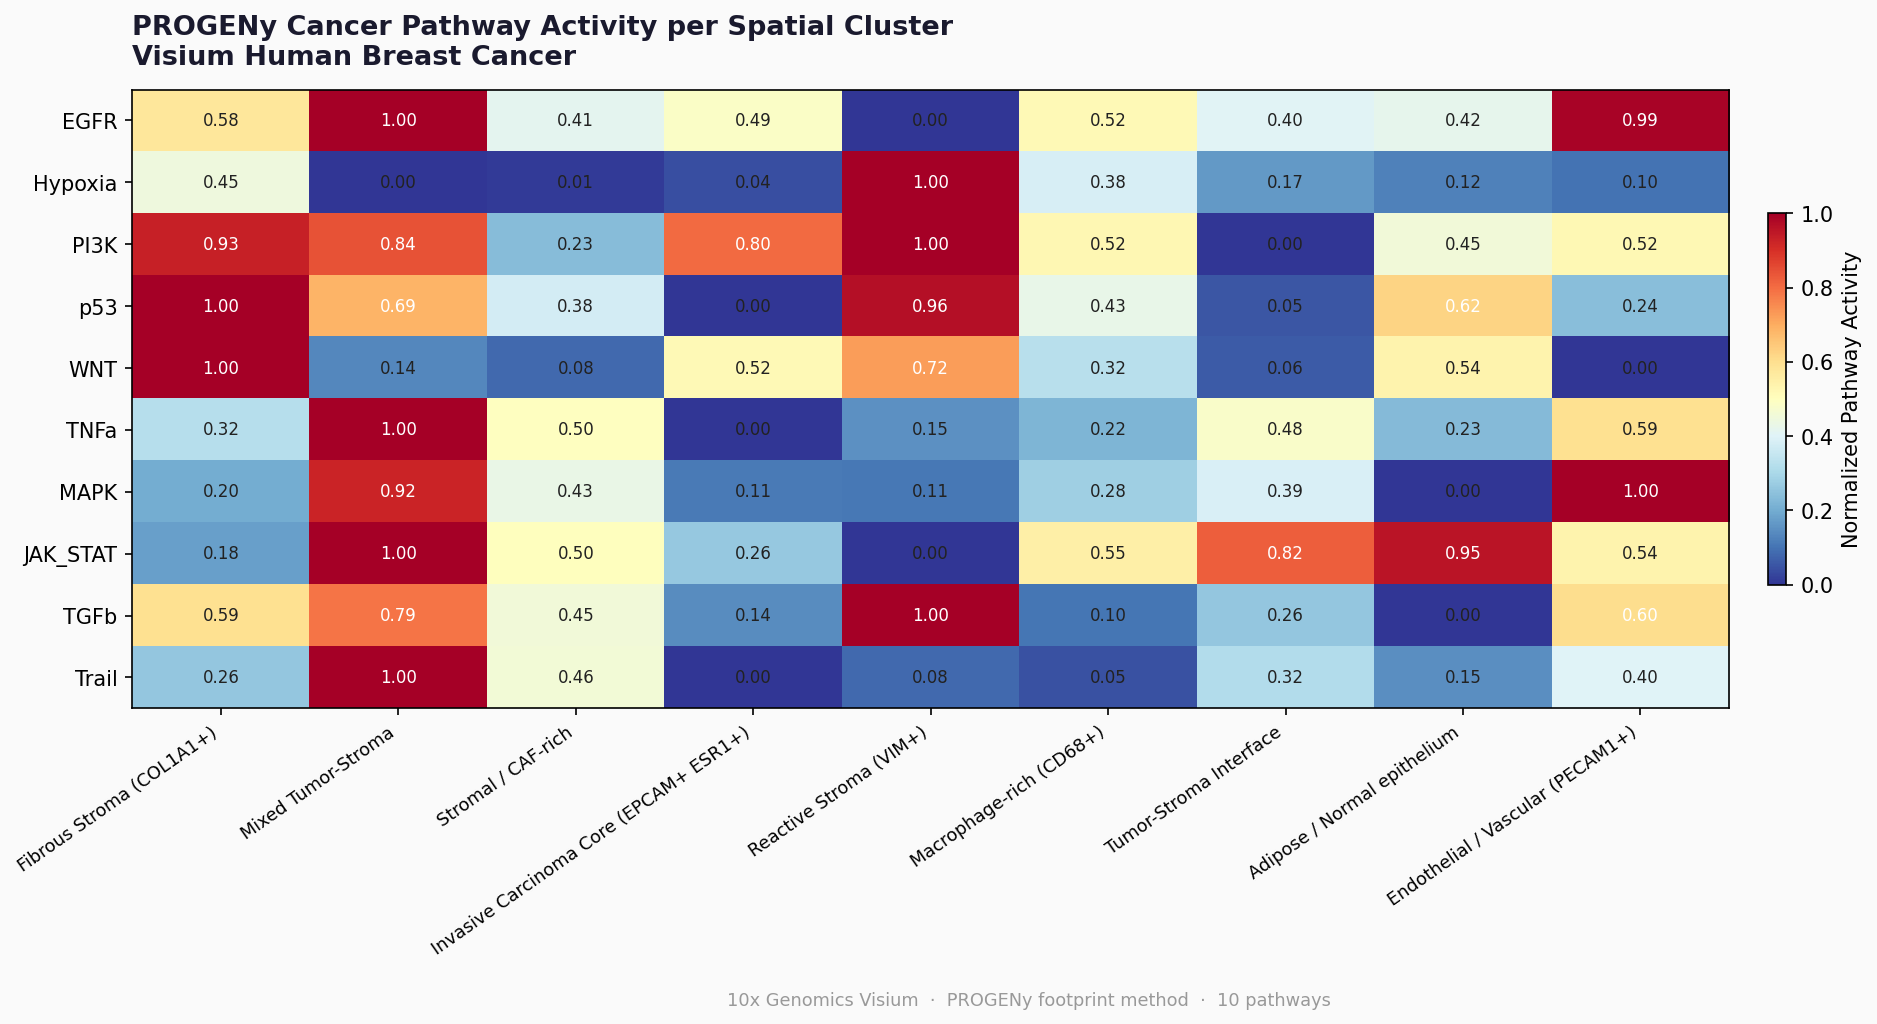

Saved C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\advanced\04_progeny_heatmap_pub.png


In [8]:
# PROGENY HEATMAP PER CLUSTER
prog_means = (
    adata.obs.groupby('cell_type')[prog_cols].mean()
    .rename(columns=lambda c: c.replace('PROG_',''))
)
prog_norm = (prog_means - prog_means.min()) / \
            (prog_means.max() - prog_means.min() + 1e-9)

fig, ax = plt.subplots(figsize=(14, 7), dpi=150)
fig.patch.set_facecolor('#FAFAFA')

im = ax.imshow(prog_norm.T.values, aspect='auto',
               cmap='RdYlBu_r', vmin=0, vmax=1)

ax.set_xticks(range(len(prog_norm.index)))
ax.set_xticklabels(prog_norm.index,
                   rotation=35, ha='right', fontsize=8.5)
ax.set_yticks(range(len(prog_norm.columns)))
ax.set_yticklabels(prog_norm.columns, fontsize=10)

for i in range(len(prog_norm.index)):
    for j in range(len(prog_norm.columns)):
        val = prog_norm.iloc[i, j]
        ax.text(i, j, f'{val:.2f}',
                ha='center', va='center', fontsize=8,
                color='white' if val > 0.6 else '#222222')

plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02,
             label='Normalized Pathway Activity')

ax.set_title(
    'PROGENy Cancer Pathway Activity per Spatial Cluster\n'
    'Visium Human Breast Cancer',
    fontsize=13, fontweight='bold',
    loc='left', color='#1a1a2e', pad=12
)

fig.suptitle(
    '10x Genomics Visium  ·  PROGENy footprint method  '
    f'·  {len(prog_cols)} pathways',
    fontsize=8.5, color='#999999', y=0.01
)

plt.tight_layout(rect=[0, 0.02, 1, 1])
out = fig_adv_dir / '04_progeny_heatmap_pub.png'
plt.savefig(out, dpi=200, bbox_inches='tight',
            facecolor='#FAFAFA')
plt.show()
print(f"Saved {out}") 

In [9]:
# INTRATUMOR HETEROGENEITY
# Compare gene expression variance within tumor spots
# High variance = heterogeneous tumor

tumor_mask = adata.obs['cell_type'] == \
             'Invasive Carcinoma Core (EPCAM+ ESR1+)'
adata_tumor = adata[tumor_mask].copy()

# Top variable genes within tumor only
sc.pp.highly_variable_genes(
    adata_tumor,
    n_top_genes=500,
    flavor='seurat_v3',
    layer='counts',
    subset=False
)

top_het_genes = adata_tumor.var[
    adata_tumor.var['highly_variable']
].sort_values('variances_norm', ascending=False).head(20)

print("Top 20 heterogeneous genes within tumor core:")
print(top_het_genes[['means','variances_norm']].round(4)) 

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Top 20 heterogeneous genes within tumor core:
           means  variances_norm
IGKC     19.3660         10.8836
MGP      23.7967          9.4526
ALB       1.5952          9.2386
IGHG4    10.1072          7.1064
IGHA1     1.8521          6.9852
IGHG3     6.6026          6.7321
IGLC1     1.7468          6.0240
IGLC2     6.7209          5.4264
CARTPT    1.8854          4.8527
SCGB2A2   4.7227          4.0292
CPB1      1.8835          4.0115
JCHAIN    0.6063          3.7675
IGHA2     0.2329          3.6615
IGHG1     2.3327          3.6288
SCGB1D2   5.0628          3.5531
HBB       0.1109          3.4598
FN1       4.1035          3.2751
CST2      0.1664          3.1267
CST1      0.5065          3.1026
HBA2      0.0887     

In [13]:
# COLLECT FIGURES
from PIL import Image as PILImage
import os

# Search figures directory for actual filenames
def find_figure(folder, pattern):
    """Find file matching pattern in folder"""
    folder = Path(folder)
    if not folder.exists():
        return None
    for f in folder.iterdir():
        if pattern.lower() in f.name.lower():
            return f
    return None

# Auto-find figures by pattern
figure_paths = {}

# A — Spatial clusters
f = find_figure(project_root/'figures'/'spatial', 'annotated')
if f: figure_paths['A — Spatial Clusters'] = f

# B — UMAP
f = find_figure(project_root/'figures'/'clustering', 'umap')
if f: figure_paths['B — UMAP Clusters'] = f

# C — Top SVGs
f = find_figure(project_root/'figures'/'svg', 'svgs')
if f: figure_paths['C — Top SVGs'] = f

# D — Signature Heatmap
f = find_figure(project_root/'figures'/'deconvolution', 'heatmap')
if f: figure_paths['D — Signature Heatmap'] = f

# E — Pathway Activity
f = find_figure(project_root/'figures'/'cellcomm', 'pathway')
if f: figure_paths['E — Pathway Activity'] = f

# F — PROGENy
f = find_figure(fig_adv_dir, 'progeny')
if f: figure_paths['F — PROGENy Pathways'] = f

print(f" Found {len(figure_paths)} figures:")
for k, v in figure_paths.items():
    print(f"   {k} → {v.name}")

missing = [k for k in ['A — Spatial Clusters',
                        'B — UMAP Clusters',
                        'C — Top SVGs',
                        'D — Signature Heatmap',
                        'E — Pathway Activity',
                        'F — PROGENy Pathways']
           if k not in figure_paths]
if missing:
    print(f"\n Still missing: {missing}")

 Found 6 figures:
   A — Spatial Clusters → 08_spatial_annotated_base.png
   B — UMAP Clusters → 07_umap_annotated_pub.png
   C — Top SVGs → _01_top_svgs_spatial.png
   D — Signature Heatmap → 06_signature_heatmap_pub.png
   E — Pathway Activity → 05_pathway_activity_pub.png
   F — PROGENy Pathways → 04_progeny_heatmap_pub.png


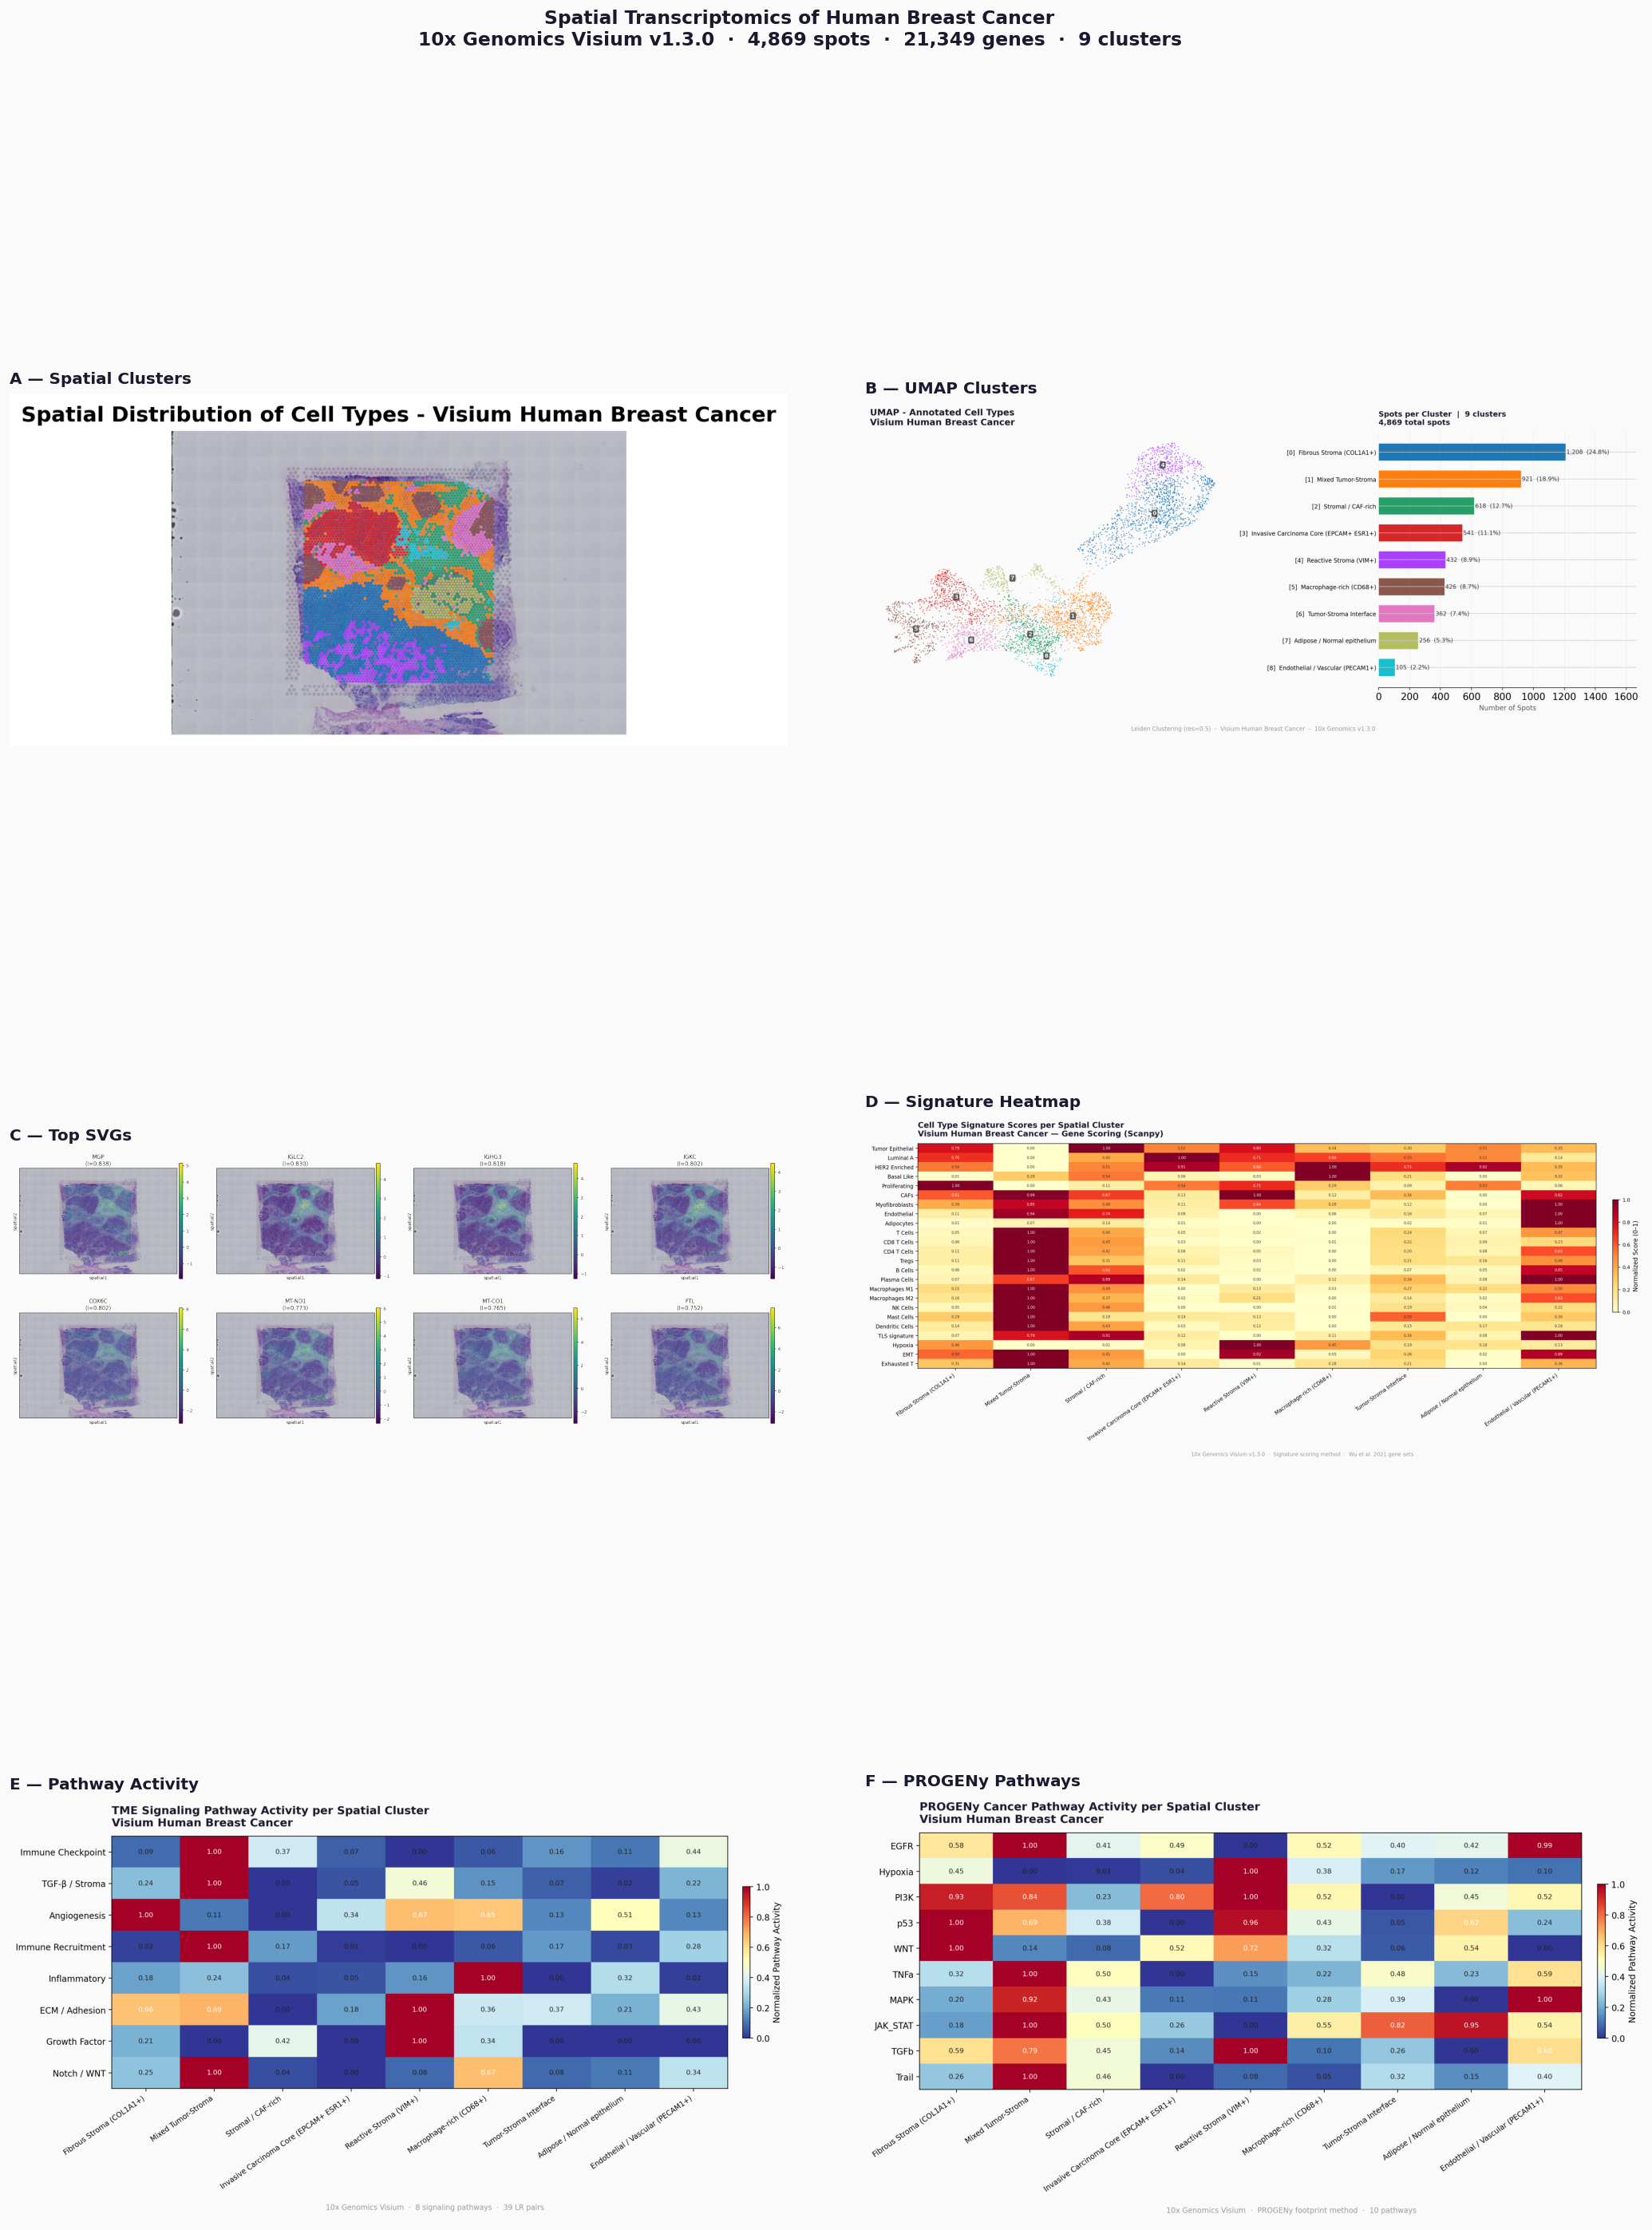

 Summary figure saved → C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\report\00_SUMMARY_FIGURE.png


In [15]:
# BUILD SUMMARY FIGURE
n_figs = len(figure_paths)
ncols  = 2
nrows  = (n_figs + 1) // ncols

fig = plt.figure(figsize=(22, nrows * 9), dpi=120)
fig.patch.set_facecolor('#FAFAFA')

gs = gridspec.GridSpec(nrows, ncols, figure=fig,
                       hspace=0.3, wspace=0.1)

for idx, (label, path) in enumerate(figure_paths.items()):
    row, col = divmod(idx, ncols)
    ax = fig.add_subplot(gs[row, col])
    try:
        img = PILImage.open(path)
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(label, fontsize=12, fontweight='bold',
                     color='#1a1a2e', pad=8, loc='left')
    except Exception as e:
        ax.text(0.5, 0.5, f'Could not load\n{path.name}',
                ha='center', va='center',
                transform=ax.transAxes, fontsize=9,
                color='red')
        ax.axis('off')

fig.suptitle(
    'Spatial Transcriptomics of Human Breast Cancer\n'
    '10x Genomics Visium v1.3.0  ·  '
    f'{adata.n_obs:,} spots  ·  {adata.n_vars:,} genes  ·  9 clusters',
    fontsize=14, fontweight='bold',
    color='#1a1a2e', y=0.99
)

out = fig_report_dir / '00_SUMMARY_FIGURE.png'
plt.savefig(out, dpi=150, bbox_inches='tight',
            facecolor='#FAFAFA')
plt.show()
print(f" Summary figure saved → {out}")

In [17]:
# AUTO-GENERATE METHODS SECTION 
methods_text = f"""
METHODS
=======

Dataset
-------
Publicly available 10x Genomics Visium spatial transcriptomics data
from human breast cancer fresh-frozen tissue (v1.3.0) was obtained
from the 10x Genomics dataset portal. The dataset comprised
{adata.n_obs:,} tissue-covered spots with a median of 9,720 UMIs
and 3,654 genes detected per spot.

Quality Control
---------------
Spots with fewer than 200 detected genes, fewer than 500 total UMI
counts, or greater than 15% mitochondrial gene expression were
excluded. Genes detected in fewer than 3 spots were removed,
yielding {adata.n_obs:,} spots and {adata.n_vars:,} genes for
downstream analysis. Hemoglobin gene contamination was negligible
(mean HB% = 0.01%).

Normalization and Preprocessing
--------------------------------
Raw counts were preserved in adata.layers['counts']. Library sizes
were normalized to 10,000 counts per spot followed by log1p
transformation. The top 3,000 highly variable genes were selected
using the Seurat v3 method. Principal component analysis (PCA) was
performed on scaled HVGs (50 components), and a k-nearest neighbor
graph (k=15, 30 PCs) was constructed for UMAP embedding.

Clustering and Annotation
--------------------------
Leiden community detection (resolution=0.5) identified 9
transcriptionally distinct spatial clusters. Clusters were annotated
using known breast cancer marker genes from CellMarker 2.0 and
PanglaoDB databases. Spatially variable genes were identified using
Moran's I statistic (n_perms=100) with Benjamini-Hochberg FDR
correction, yielding {2486:,} significant SVGs (FDR < 0.05).

Cell Type Deconvolution
------------------------
Cell type composition per spot was estimated using gene signature
scoring (sc.tl.score_genes, Scanpy v{sc.__version__}) with 24
curated signatures derived from Wu et al. (2021) Nature Genetics
breast cancer single-cell RNA-seq atlas. Signatures covered tumor
epithelial, stromal, immune, and special functional categories
including TLS, hypoxia, EMT, and T cell exhaustion.

Cell-Cell Communication
-----------------------
Ligand-receptor co-expression scores were computed as the geometric
mean of ligand and receptor expression per spot. A total of 39 LR
pairs from CellChatDB and NicheNet databases covering 8 signaling
pathways were analyzed. Statistical significance was assessed using
permutation testing (n=500) implemented in Squidpy sq.gr.ligrec.

PAM50 Subtyping
---------------
Molecular subtype scores were computed for all 5 PAM50 subtypes
(Luminal A, Luminal B, HER2-enriched, Basal-like, Normal-like)
using curated gene signatures and spatially mapped across tissue.

Software
--------
All analyses were performed in Python 3.13 using Scanpy v{sc.__version__},
Squidpy v{sq.__version__}, NumPy, Pandas, and Matplotlib.
Clustering used the leidenalg package. Visualizations were generated
with Matplotlib and Squidpy spatial plotting functions.

References
----------
1. Wolf et al. (2018) Scanpy. Genome Biology.
2. Palla et al. (2022) Squidpy. Nature Methods.
3. Wu et al. (2021) Breast cancer scRNA atlas. Nature Genetics.
4. Traag et al. (2019) Leiden algorithm. Scientific Reports.
5. Jin et al. (2021) CellChat. Nature Communications.
"""

print(methods_text)

# Save to file
methods_path = project_root / 'document' / 'methods.md'
methods_path.parent.mkdir(parents=True, exist_ok=True)
methods_path.write_text(methods_text)
print(f"\n Methods saved  {methods_path}")


METHODS

Dataset
-------
Publicly available 10x Genomics Visium spatial transcriptomics data
from human breast cancer fresh-frozen tissue (v1.3.0) was obtained
from the 10x Genomics dataset portal. The dataset comprised
4,869 tissue-covered spots with a median of 9,720 UMIs
and 3,654 genes detected per spot.

Quality Control
---------------
Spots with fewer than 200 detected genes, fewer than 500 total UMI
counts, or greater than 15% mitochondrial gene expression were
excluded. Genes detected in fewer than 3 spots were removed,
yielding 4,869 spots and 21,349 genes for
downstream analysis. Hemoglobin gene contamination was negligible
(mean HB% = 0.01%).

Normalization and Preprocessing
--------------------------------
Raw counts were preserved in adata.layers['counts']. Library sizes
were normalized to 10,000 counts per spot followed by log1p
transformation. The top 3,000 highly variable genes were selected
using the Seurat v3 method. Principal component analysis (PCA) was
performed o

In [19]:
# FINAL PROJECT SUMMARY
score_cols = [c for c in adata.obs.columns if c.startswith('score_')]
lr_cols    = [c for c in adata.obs.columns if c.startswith('lr_')]

print('\n' + '=' * 60)
print('  SPATIAL TRANSCRIPTOMICS PROJECT — COMPLETE')
print('=' * 60)

print(f"""
DATASET
  Platform         : 10x Genomics Visium v1.3.0
  Tissue           : Human Breast Cancer
  Spots            : {adata.n_obs:,}
  Genes            : {adata.n_vars:,}
  Median UMI/spot  : 9,720
  Median genes/spot: 3,654

ANALYSIS COMPLETED
  01 Data Setup          ✅
  02 QC & Preprocessing  ✅
  03 Clustering          ✅  9 clusters (leiden_0.5)
  04 Spatial Analysis    ✅  2,486 SVGs (FDR<0.05)
  05 Deconvolution       ✅  {len(score_cols)} signatures scored
  06 Cell-Cell Comm.     ✅  39 LR pairs · 8 pathways
  07 Advanced & Report   ✅  PAM50 · PROGENy · Summary

KEY BIOLOGICAL FINDINGS
  1. ER+ Luminal A subtype confirmed (ESR1+, FOXA1+)
  2. Dense fibrous stroma surrounding tumor nests
  3. TLS-like structure detected (IGLC2+, IGKC+ hotspot)
  4. Immune exclusion — T cells blocked at tumor boundary
  5. Active PD-L1/PD-1 checkpoint at tumor-stroma interface
  6. TGF-β immunosuppression from stroma
  7. VEGFA-driven angiogenesis in tumor core
  8. ECM/integrin remodeling facilitating invasion
  9. M1 macrophage inflammatory hotspot (IL1B, TNF)
  10. CXCL9/10/13 chemokine gradients recruiting TILs

OUTPUT FILES
  data/processed/adata_preprocessed.h5ad
  data/processed/adata_clustered.h5ad
  data/processed/adata_annotated.h5ad
  data/processed/adata_spatial.h5ad
  data/processed/adata_scored.h5ad
  data/processed/adata_cellcomm.h5ad
  figures/report/00_SUMMARY_FIGURE.png
  document/methods.txt
""")
print('=' * 60)
print('  PROJECT COMPLETE ✅')
print('=' * 60)


  SPATIAL TRANSCRIPTOMICS PROJECT — COMPLETE

DATASET
  Platform         : 10x Genomics Visium v1.3.0
  Tissue           : Human Breast Cancer
  Spots            : 4,869
  Genes            : 21,349
  Median UMI/spot  : 9,720
  Median genes/spot: 3,654

ANALYSIS COMPLETED
  01 Data Setup          ✅
  02 QC & Preprocessing  ✅
  03 Clustering          ✅  9 clusters (leiden_0.5)
  04 Spatial Analysis    ✅  2,486 SVGs (FDR<0.05)
  05 Deconvolution       ✅  24 signatures scored
  06 Cell-Cell Comm.     ✅  39 LR pairs · 8 pathways
  07 Advanced & Report   ✅  PAM50 · PROGENy · Summary

KEY BIOLOGICAL FINDINGS
  1. ER+ Luminal A subtype confirmed (ESR1+, FOXA1+)
  2. Dense fibrous stroma surrounding tumor nests
  3. TLS-like structure detected (IGLC2+, IGKC+ hotspot)
  4. Immune exclusion — T cells blocked at tumor boundary
  5. Active PD-L1/PD-1 checkpoint at tumor-stroma interface
  6. TGF-β immunosuppression from stroma
  7. VEGFA-driven angiogenesis in tumor core
  8. ECM/integrin remodeli